In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


* Coverting order date into date time format

In [2]:
dataset = pd.read_csv("data/superstore.csv", encoding="latin1")

dataset['Order Date'] = pd.to_datetime(dataset['Order Date'])
dataset.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


* Creating a dataframe by combining all the sales, profit, order ID, Discount and Order date of eacch customers into a single row for each customer

In [3]:
customer_df = dataset.groupby('Customer ID').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Order ID': 'count',
    'Discount': 'mean',
    'Order Date': 'max'
}).reset_index()
customer_df

,Customer ID,Sales,Profit,Order ID,Discount,Order Date
0,AA-10315,5563.560,-362.8825,11,0.090909,2017-06-29
1,AA-10375,1056.390,277.3824,15,0.080000,2017-12-11
2,AA-10480,1790.512,435.8274,12,0.016667,2017-04-15
3,AA-10645,5086.935,857.8033,18,0.063889,2017-11-05
4,AB-10015,886.156,129.3465,6,0.066667,2016-11-10
...,...,...,...,...,...,...
788,XP-21865,2374.658,621.2300,28,0.046429,2017-11-17
789,YC-21895,5454.350,1305.6290,8,0.075000,2017-12-26
790,YS-21880,6720.444,1778.2923,12,0.050000,2017-12-21
791,ZC-21910,8025.707,-1032.1490,31,0.254839,2017-11-06


* Changing the column names

In [4]:
customer_df.columns = [
    'Customer_ID',
    'Total_Sales',
    'Total_Profit',
    'Total_Orders',
    'Avg_Discount',
    'Last_Purchase_Date'
]


* For finding the duration of last purchase for each customer creating a new column reference date with recent order date of customer with last_purchase_date column already present in the dataset, So with these two by subracting and converting in days type, we'll be getting the exact days for each customer

In [5]:
reference_date = dataset['Order Date'].max()
customer_df['Recency_Days'] = (
    reference_date - customer_df['Last_Purchase_Date']
).dt.days


* Dropping Last_purchase_date column since it's not necessary

In [6]:
customer_df.drop(columns=['Last_Purchase_Date'], inplace=True)
customer_df.head()


,Customer_ID,Total_Sales,Total_Profit,Total_Orders,Avg_Discount,Recency_Days
0,AA-10315,5563.560,-362.8825,11,0.090909,184
1,AA-10375,1056.390,277.3824,15,0.080000,19
2,AA-10480,1790.512,435.8274,12,0.016667,259
3,AA-10645,5086.935,857.8033,18,0.063889,55
4,AB-10015,886.156,129.3465,6,0.066667,415


* Taking columns with different scale units to assign it to a new variable called features

In [7]:
features = customer_df[
    ['Total_Sales', 'Total_Profit', 'Total_Orders', 'Avg_Discount', 'Recency_Days']
]


* Implementing standard scaler as every columnn has different measure units

In [8]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


* Implementing elbow method to find how many clusters needed for our model

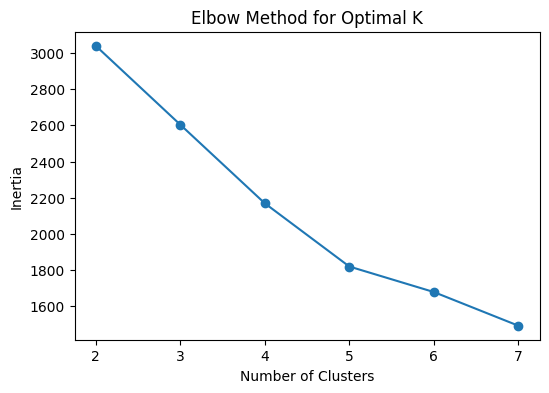

In [9]:
inertia = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2, 8), inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


* checking the score for each clusters to see which one is in more center for each customer k values

In [10]:
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    print(f"K={k}, Silhouette Score={score:.3f}")


K=2, Silhouette Score=0.252
K=3, Silhouette Score=0.212
K=4, Silhouette Score=0.219
K=5, Silhouette Score=0.242
K=6, Silhouette Score=0.240
K=7, Silhouette Score=0.249


* From the above we can see that k=3 has the best score. so we'll go with 3 clusters and fit prediciting the model by creating a new column called cluster

In [11]:
kmeans = KMeans(n_clusters=3, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(scaled_features)


* To group the columns according to cluster column, we need to take out columns with int or float from whole dataframe. Since, the dataframe has many data types

In [12]:
numeric_cols = [
    'Total_Sales',
    'Total_Profit',
    'Total_Orders',
    'Avg_Discount',
    'Recency_Days'
]


In [13]:
cluster_summary = customer_df.groupby('Cluster')[numeric_cols].mean()
cluster_summary


,Total_Sales,Total_Profit,Total_Orders,Avg_Discount,Recency_Days
Cluster,,,,,
0,3064.571085,331.329859,15.130751,0.139755,70.348668
1,1340.674808,21.013713,7.583871,0.189394,252.716129
2,8798.911599,2043.479129,19.914286,0.120740,128.828571


* From the above we can see the mean for each cluster ie each group of customers average and below we'll visualise it and take a look

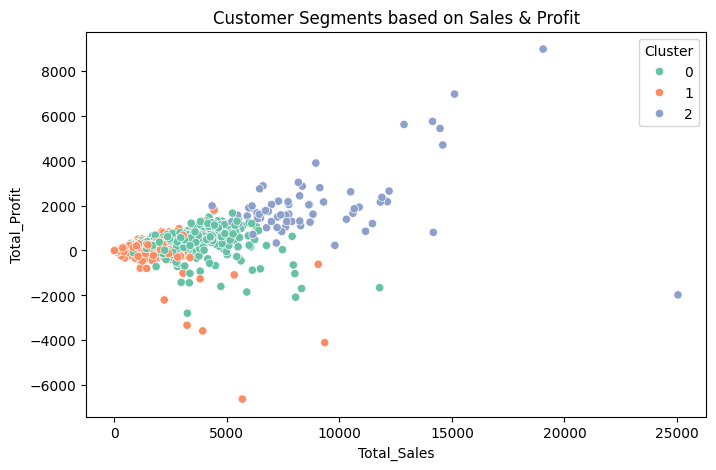

In [14]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=customer_df,
    x='Total_Sales',
    y='Total_Profit',
    hue='Cluster',
    palette='Set2'
)
plt.title("Customer Segments based on Sales & Profit")
plt.show()


* Below we are calculating the average value per order for each customers

In [28]:
customer_df['Avg_Order_Value'] = (
    customer_df['Total_Sales'] / customer_df['Total_Orders']
)
customer_df


,index,Customer_ID,Total_Sales,Total_Profit,Total_Orders,Avg_Discount,Recency_Days,Cluster,Avg_Order_Value,Customer_Lifespan,CLV,CLV_Segment
0,0,AA-10315,5563.560,-362.8825,11,0.090909,184,0,505.778182,2.687671,14953.020164,High Value
1,1,AA-10375,1056.390,277.3824,15,0.080000,19,0,70.426000,3.139726,3316.775178,Low Value
2,2,AA-10480,1790.512,435.8274,12,0.016667,259,0,149.209333,2.482192,4444.394170,Medium Value
3,3,AA-10645,5086.935,857.8033,18,0.063889,55,0,282.607500,3.041096,15469.857123,High Value
4,4,AB-10015,886.156,129.3465,6,0.066667,415,1,147.692667,2.054795,1820.868493,Low Value
...,...,...,...,...,...,...,...,...,...,...,...,...
788,788,XP-21865,2374.658,621.2300,28,0.046429,43,0,84.809214,3.073973,7299.633633,Medium Value
789,789,YC-21895,5454.350,1305.6290,8,0.075000,4,0,681.793750,3.180822,17349.316027,High Value
790,790,YS-21880,6720.444,1778.2923,12,0.050000,9,2,560.037000,3.167123,21284.474696,High Value
791,791,ZC-21910,8025.707,-1032.1490,31,0.254839,54,0,258.893774,3.043836,24428.932814,High Value


* Calculating the lifespan of the customer by seeing the difference between longest inactive customer with each customer recent buys and converting into years

In [29]:
customer_df['Customer_Lifespan'] = (
    customer_df['Recency_Days'].max() - customer_df['Recency_Days']
) / 365

customer_df

,index,Customer_ID,Total_Sales,Total_Profit,Total_Orders,Avg_Discount,Recency_Days,Cluster,Avg_Order_Value,Customer_Lifespan,CLV,CLV_Segment
0,0,AA-10315,5563.560,-362.8825,11,0.090909,184,0,505.778182,2.687671,14953.020164,High Value
1,1,AA-10375,1056.390,277.3824,15,0.080000,19,0,70.426000,3.139726,3316.775178,Low Value
2,2,AA-10480,1790.512,435.8274,12,0.016667,259,0,149.209333,2.482192,4444.394170,Medium Value
3,3,AA-10645,5086.935,857.8033,18,0.063889,55,0,282.607500,3.041096,15469.857123,High Value
4,4,AB-10015,886.156,129.3465,6,0.066667,415,1,147.692667,2.054795,1820.868493,Low Value
...,...,...,...,...,...,...,...,...,...,...,...,...
788,788,XP-21865,2374.658,621.2300,28,0.046429,43,0,84.809214,3.073973,7299.633633,Medium Value
789,789,YC-21895,5454.350,1305.6290,8,0.075000,4,0,681.793750,3.180822,17349.316027,High Value
790,790,YS-21880,6720.444,1778.2923,12,0.050000,9,2,560.037000,3.167123,21284.474696,High Value
791,791,ZC-21910,8025.707,-1032.1490,31,0.254839,54,0,258.893774,3.043836,24428.932814,High Value


* Creating a new column called CLV aka customer lifetime value by calculating the avergae order cost with total orders made by each customer and followed by their lifespan

In [18]:
customer_df['CLV'] = (
    customer_df['Avg_Order_Value'] *
    customer_df['Total_Orders'] *
    customer_df['Customer_Lifespan']
)


* Creating groups by using qcut which divides and q=3 for how many groups and giving it the labels for each groups. So, this step is segmentation

In [19]:
customer_df['CLV_Segment'] = pd.qcut(
    customer_df['CLV'],
    q=3,
    labels=['Low Value', 'Medium Value', 'High Value']
)


* Just seeing the first 5 rows

In [23]:
customer_df[['Customer_ID', 'CLV', 'CLV_Segment']].head()


,Customer_ID,CLV,CLV_Segment
0,AA-10315,14953.020164,High Value
1,AA-10375,3316.775178,Low Value
2,AA-10480,4444.394170,Medium Value
3,AA-10645,15469.857123,High Value
4,AB-10015,1820.868493,Low Value


* Here is the info of value counts of each group

In [24]:
customer_df['CLV_Segment'].value_counts()


CLV_Segment
High Value      265
Low Value       264
Medium Value    264
Name: count, dtype: int64

* We can take a look below and see the customers and their values

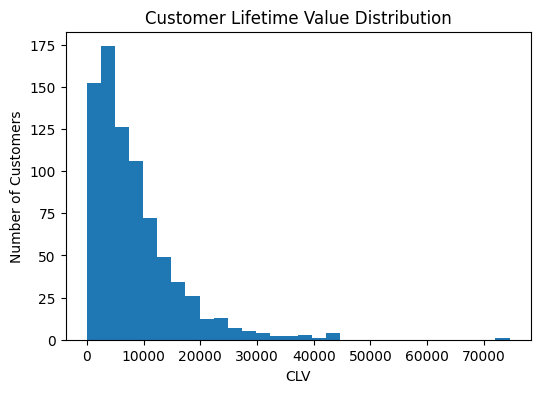

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(customer_df['CLV'], bins=30)
plt.title("Customer Lifetime Value Distribution")
plt.xlabel("CLV")
plt.ylabel("Number of Customers")
plt.show()


* Grouping by the segment column with mean to take a better look of each group customers and their values which is perfectly like we predicted

C:\Users\sanja\AppData\Local\Temp\ipykernel_16612\1514402662.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  customer_df.groupby('CLV_Segment')['CLV'].mean().plot(kind='bar', figsize=(6,4))


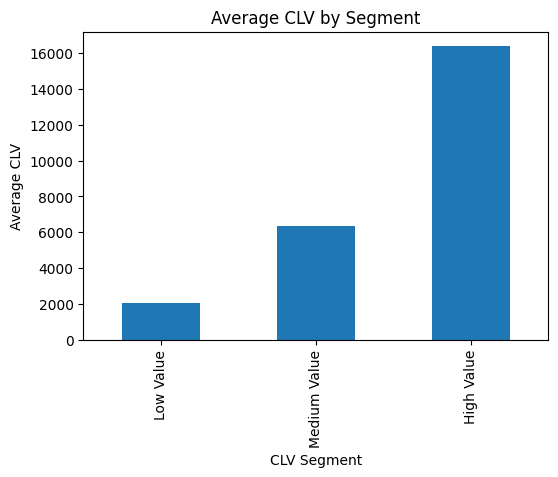

In [27]:
customer_df.groupby('CLV_Segment')['CLV'].mean().plot(kind='bar', figsize=(6,4))
plt.title("Average CLV by Segment")
plt.ylabel("Average CLV")
plt.xlabel("CLV Segment")
plt.show()
